# Digging further: Percentage double-scored

In this notebook we look how PRMSE depends on % double-scored responses. 
We pick 100 rater pairs, sample different % of double-scored responses and compute PRMSE. 

In [2]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import itertools
import numpy as np

import json

from rsmtool.utils.prmse import prmse_true
from rsmtool.analyzer import Analyzer

from matplotlib import pyplot as plt

from pathlib import Path

%matplotlib inline

In [3]:
# let's define some settings and read the data
config = json.load(open('settings.json'))
fig_dir = Path('../paper_overleaf/figures')
df = pd.read_csv('../data/data.csv')
df_raters = pd.read_csv('../data/raters.csv')
metrics_dict = json.load(open('metrics_dict.json')) # the dictionary with metrics name we'll use for plots
df['system'] = df[config['sample_system']] # we use one sample system as defined in the config

In [4]:
human_columns = df_raters['rater_id'].values

In [5]:
# generate pairs of raters for each group

def generate_rater_pairs_for_group(df_group, n_pairs):
    raters = df_group['rater_id']
    # get all possible rater pairs
    rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]
    np.random.seed(100)
    selected_pairs = np.random.choice(rater_pairs, n_pairs, replace=False)
    return selected_pairs

In [6]:
# randomly sample 50 pairs for each group
selected_pairs = df_raters.groupby('category').apply(generate_rater_pairs_for_group, n_pairs=50)
pair_dict = selected_pairs.to_dict()

In [7]:
# we make one long DF to speed up computation
data = []
for c in df_raters['category'].unique():
    pairs = pair_dict[c]
    for p in pairs:
        (h1, h2) = p.split('+')
        df_p = pd.DataFrame({'pair': p,
                              'h1': df[h1],
                              'h2': df[h2],
                              'system': df['system'], 
                              'true': df['true'],
                              'category': c})
        data.append(df_p)
    df_long = pd.concat(data)

In [8]:
# let's now create a DF with different percentage double-scored
perc_double_scored = [1, 2.5, 5, 10, 25, 50, 100]
# we now create a df with this values
np.random.seed(123)
df_list = []
for p in perc_double_scored:
    print(p)
    to_sample = int(p/100*len(df_long))
    mask  = np.zeros(len(df_long), dtype=int)
    mask[: to_sample]=1
    np.random.shuffle(mask)
    mask = mask.astype(bool)
    df_double = df_long[mask].copy()
    df_single = df_long[~mask].copy()
    df_double['percentage'] = p
    df_single['percentage'] = p
    df_single['h2'] = None
    df_list.extend([df_double, df_single])
df_perc = pd.concat(df_list)
df_perc['h1'] = pd.to_numeric(df_perc['h1'], errors='coerce')
df_perc['h2'] = pd.to_numeric(df_perc['h2'], errors='coerce')

1
2.5
5
10
25
50
100


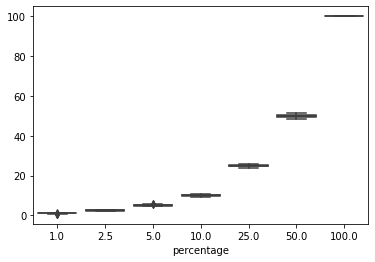

In [9]:
# A sanity check plot
sns.boxplot(data=df_perc.groupby(['pair', 'percentage']).apply(lambda x: len(x[~x['h2'].isnull()])/len(x)*100).unstack())

In [10]:
# now let's compute prmse. This can take a lot of time since we are computing over a large amount of data:
# 200 pairs, 7 percentage points. 
df_prmse  = df_perc.groupby(['pair', 'percentage']).apply(lambda x: prmse_true(x['system'],
                                                                               x[['h1', 'h2']])).reset_index()

In [11]:
df_prmse.columns = ['pair', 'percentage', 'prmse']
df_prmse['N double-scored'] = (df_prmse['percentage']*len(df)/100).astype(int)

# add rater category
df_prmse['h1'] = df_prmse['pair'].apply(lambda x: x.split("+")[0])
df_prmse_with_category = pd.merge(df_prmse, df_raters, left_on='h1', right_on='rater_id')

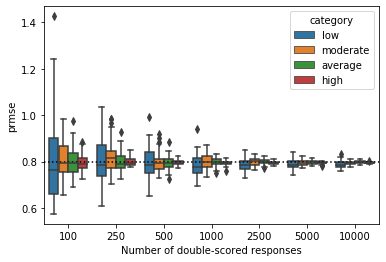

In [12]:
# plot by category
ax = sns.boxplot(x='N double-scored', y='prmse', hue='category',
                 hue_order=config['rater_categories'],
                 data=df_prmse_with_category)
ax.set_xlabel("Number of double-scored responses")
ax.axhline(r2_score(df['true'], df['system']), color='black', ls=':')
plt.savefig(fig_dir / 'percentage.png')

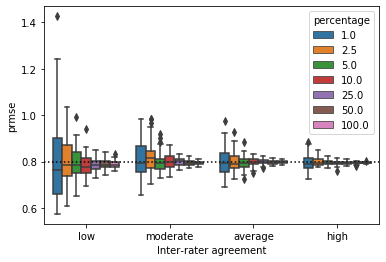

In [13]:
# do the same by percentage
ax = sns.boxplot(x='category', y='prmse', hue='percentage',
                 order=config['rater_categories'],
                 data=df_prmse_with_category)
ax.set_xlabel("Inter-rater agreement")
ax.axhline(r2_score(df['true'], df['system']), color='black', ls=':')
#plt.savefig(fig_dir / 'percentage.png')

In [14]:
df_prmse_with_category.groupby(['category', 'percentage'])['prmse'].describe()

count      mean       std       min       25%       50%  \
category percentage                                                            
average  1.0          50.0  0.797375  0.065570  0.690098  0.753711  0.793128   
         2.5          50.0  0.799307  0.041302  0.726475  0.771860  0.789150   
         5.0          50.0  0.795292  0.028088  0.726930  0.776779  0.795177   
         10.0         50.0  0.798842  0.018902  0.749213  0.788979  0.798856   
         25.0         50.0  0.798970  0.010538  0.772304  0.793735  0.798341   
         50.0         50.0  0.797638  0.009296  0.783217  0.789771  0.797648   
         100.0        50.0  0.797993  0.006176  0.786276  0.794200  0.798012   
high     1.0          50.0  0.795679  0.035503  0.724373  0.772605  0.790350   
         2.5          50.0  0.801229  0.020644  0.775189  0.785601  0.794720   
         5.0          50.0  0.796727  0.012820  0.774335  0.788591  0.795629   
         10.0         50.0  0.793199  0.010177  0.759234  0.788899  0.793103   
         25.0         50.0  0.794274  0.006577  0.782355  0.789957  0.794250   
         50.0         50.0  0.794805  0.004878  0.779402  0.792379  0.794668   
         100.0        50.0  0.794571  0.002894  0.789072  0.792730  0.794620   
low      1.0          50.0  0.802066  0.180873  0.574960  0.660486  0.763634   
         2.5          50.0  0.808592  0.104597  0.610011  0.739795  0.784806   
         5.0          50.0  0.791160  0.070193  0.651979  0.749111  0.785497   
         10.0         50.0  0.785622  0.044788  0.694753  0.751780  0.777787   
         25.0         50.0  0.783609  0.027215  0.727720  0.766161  0.783701   
         50.0         50.0  0.787675  0.021847  0.742756  0.775011  0.785537   
         100.0        50.0  0.788335  0.013956  0.758263  0.778119  0.785620   
moderate 1.0          50.0  0.807175  0.079861  0.656875  0.755464  0.793017   
         2.5          50.0  0.820874  0.067302  0.704018  0.772728  0.816271   
         5.0          50.0  0.799756  0.042210  0.727569  0.769671  0.793422   
         10.0         50.0  0.801221  0.028984  0.731826  0.778637  0.797963   
         25.0         50.0  0.799652  0.016287  0.764457  0.786162  0.802690   
         50.0         50.0  0.795126  0.011798  0.773444  0.786412  0.794797   
         100.0        50.0  0.795663  0.008237  0.778666  0.789868  0.795231   

                          75%       max  
category percentage                      
average  1.0         0.838146  0.976487  
         2.5         0.822939  0.926200  
         5.0         0.809271  0.885146  
         10.0        0.810741  0.833599  
         25.0        0.806717  0.822787  
         50.0        0.802809  0.816678  
         100.0       0.801590  0.812113  
high     1.0         0.814887  0.882525  
         2.5         0.811302  0.848086  
         5.0         0.804790  0.825609  
         10.0        0.799107  0.813665  
         25.0        0.799012  0.811106  
         50.0        0.797526  0.804510  
         100.0       0.796432  0.802677  
low      1.0         0.901708  1.425568  
         2.5         0.871556  1.037124  
         5.0         0.841111  0.990940  
         10.0        0.813628  0.941502  
         25.0        0.801179  0.850729  
         50.0        0.802775  0.840556  
         100.0       0.796257  0.832655  
moderate 1.0         0.867577  0.981308  
         2.5         0.844310  0.983603  
         5.0         0.812609  0.918756  
         10.0        0.822267  0.872613  
         25.0        0.812287  0.831042  
         50.0        0.803331  0.823871  
         100.0       0.799917  0.812767

In [15]:
# let's check if it's % or number
df_double_only = df_perc[~df_perc['h2'].isnull()]
len(df_perc), len(df_double_only)

(14000000, 3870000)

In [ ]:
# now let's re-compute prmse. This can take a lot of time again since we are computing over a large amount of data:
# 200 pairs, 7 percentage points. 
df_prmse_double  = df_double_only.groupby(['pair', 'percentage']).apply(lambda x: prmse_true(x['system'],
                                                                               x[['h1', 'h2']])).reset_index()

In [ ]:
df_prmse_double.columns = ['pair', 'percentage', 'prmse']

df_prmse_double['Total N'] = df_prmse_double['percentage']*len(df)/100

# add rater category
df_prmse_double['h1'] = df_prmse_double['pair'].apply(lambda x: x.split("+")[0])
df_prmse_double_with_category = pd.merge(df_prmse_double, df_raters, left_on='h1', right_on='rater_id')

In [ ]:
# plot by category
ax = sns.boxplot(x='Total N', y='prmse', hue='category',
                 hue_order=config['rater_categories'],
                 data=df_prmse_double_with_category)
ax.set_xlabel("Total N responses")
ax.axhline(r2_score(df['true'], df['system']), color='black', ls=':')

In [ ]:
#let's also look at other metrics
df_perc['h_mean'] = df_perc[['h1', 'h2']].mean(axis=1)
df_metrics = df_perc.groupby(['pair', 'percentage']).apply(lambda x: Analyzer.metrics_helper(x['h_mean'], x['system']))

In [ ]:
df_metrics.reset_index(inplace=True)

In [ ]:
df_metrics_long = df_metrics.melt(id_vars = ['pair', 'percentage'],
                                 value_vars = ['wtkappa', 'corr', 'R2'],
                                 var_name = 'metrics', 
                                 value_name = 'value')
df_metrics_long['h1'] = df_metrics_long['pair'].apply(lambda x: x.split("+")[0])
df_metrics_with_category = pd.merge(df_metrics_long, df_raters, left_on='h1', right_on='rater_id')

In [ ]:
ax = sns.catplot(x='category', y='value', col='metrics',
                 hue='percentage', order=config['rater_categories'],
                 data=df_metrics_with_category, kind='box',
                sharey=False)
plt.savefig(fig_dir / 'percentage_other.png')